In [1]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/ModelsResults')

from mvesc_utility_functions import *
from estimate_prediction_model import *
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '08_12_2016_grade_10_param_set_22_RF_ht_23591'
#filename = '08_12_2016_grade_10_param_set_16_RF_ht_22199'

with open('/mnt/data/mvesc/Models_Results/pkls/'+filename+'_RF.pkl', "rb" ) as f:
    d = pickle.load(f)
model_options = d['model_options']
d.keys()


dict_keys(['model_options', 'val_set_preds', 'val_set_soft_preds', 'model_name', 'cross_validation_scores', 'features', 'test_set_preds', 'test_set_soft_preds', 'train_set_balance', 'train_y', 'parameter_grid', 'estimator', 'train_set_soft_preds', 'file_name', 'val_y', 'test_y', 'train_set_preds', 'time'])

In [3]:
model_options['cohorts_training']

[2007, 2008, 2009, 2010, 2011]

In [4]:
model = d['estimator']

In [5]:
len(model.feature_importances_) 

86

In [6]:
outcome_plus_features = build_outcomes_plus_features(model_options,None)
outcome_plus_features.dropna(subset=[model_options['outcome_name'],
        model_options['cohort_grade_level_begin']], inplace=True)

In [7]:
train, val, test = temporal_cohort_test_split(outcome_plus_features,
            model_options['cohort_grade_level_begin'],
            model_options['cohorts_test'],
            model_options['cohorts_val'],
            model_options['cohorts_training'])

In [8]:
train_X = train.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
test_X = test.drop([model_options['outcome_name'],
                    model_options['cohort_grade_level_begin']],axis=1)
val_X = val.drop([model_options['outcome_name'],
                  model_options['cohort_grade_level_begin']],axis=1)
train_y = train[model_options['outcome_name']]
test_y = test[model_options['outcome_name']]
val_y = val[model_options['outcome_name']]

In [9]:
train_X, val_X, test_X = impute_missing_values(train_X, val_X, test_X,\
    model_options['missing_impute_strategy'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"


In [10]:
train_X, val_X, test_X = scale_features(train_X, val_X, test_X,
    model_options['feature_scaling'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"
print(len(train_X.columns)) 

85


In [11]:
binary_features = pd.DataFrame(~train_X.apply(lambda x: len(x.unique()),axis=0).gt(2), columns = ['binary'])

In [12]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute("""select feature,importance from model.feature_scores
                                where filename = '{}'; """.format(filename))
        temp = cursor.fetchall()
scores = pd.DataFrame(temp, columns = ['feature','importance'])
len(scores)

85

In [13]:
scores.set_index('feature', inplace=True)

In [14]:
for a in train_X.columns:
    if a not in scores.index:
        least_important = a
        print(a)
# this is probably the least important feature, excluded from database by bug

section_504_plan_gr_9_0


In [15]:
for a in scores.index:
    if a not in train_X.columns:
        print(a)  

status_gr_9_full_college


In [16]:
print(len(train_X.columns)) # status_gr_9_full_college dropped 
print(len(scores)) # least important feature dropped
print(model.n_features_) # all features

85
85
86


In [17]:
scores = scores.merge(binary_features, left_index=True, right_index=True)
train_X.drop(least_important,axis=1,inplace=True)

In [18]:
print(len(scores.index)) # dropped status_gr_9_full_college and least important feature 
print(len(train_X.columns))

84
84


/home/jgutman/env/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


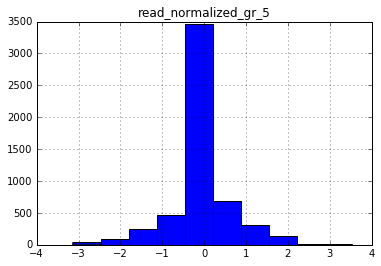

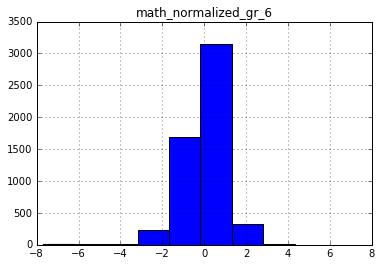

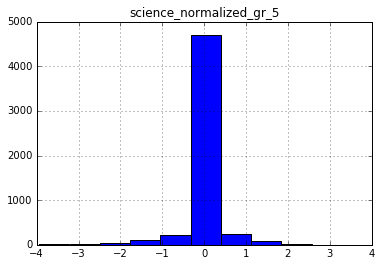

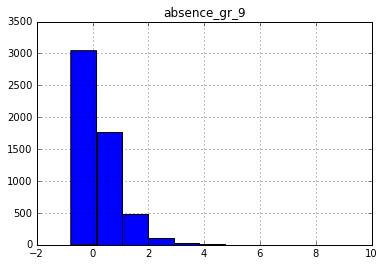

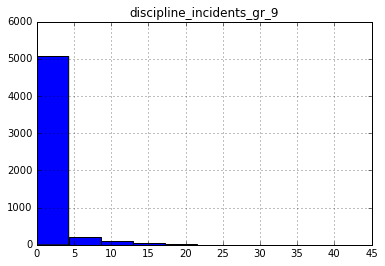

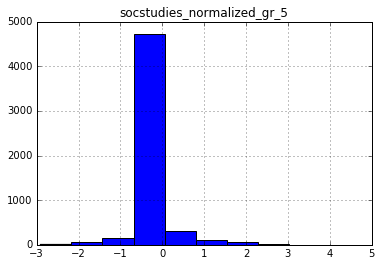

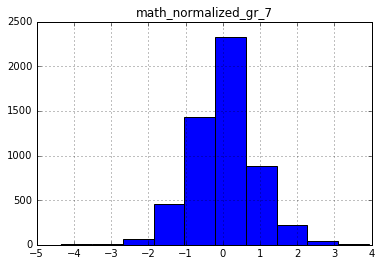

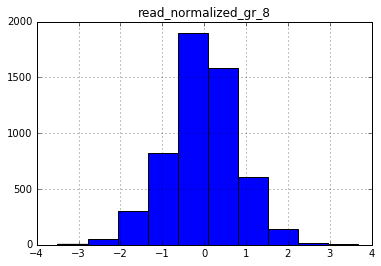

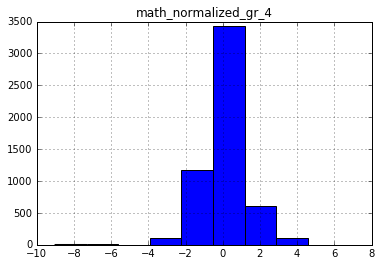

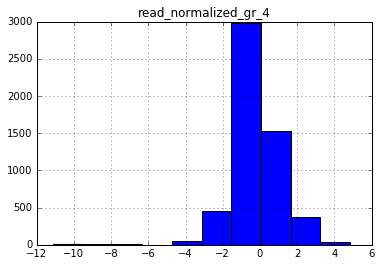

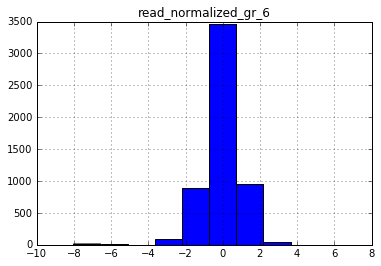

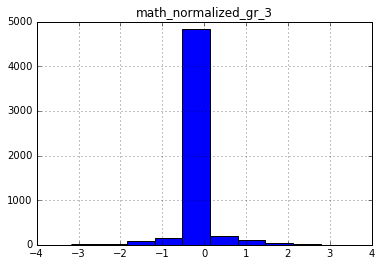

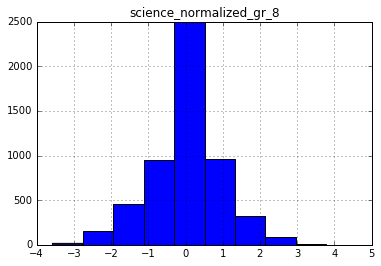

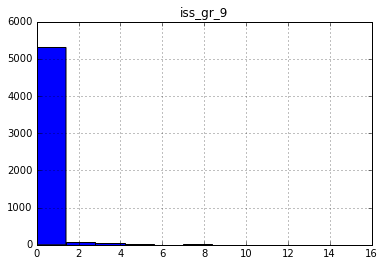

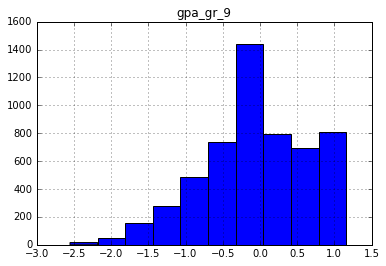

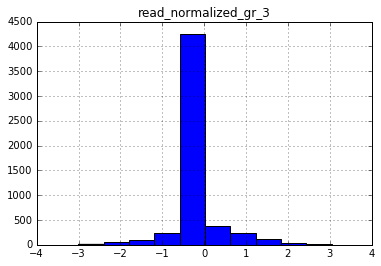

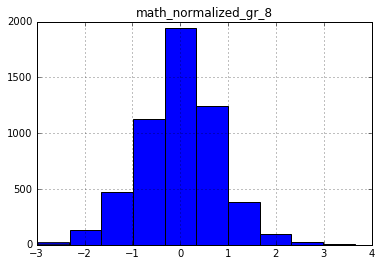

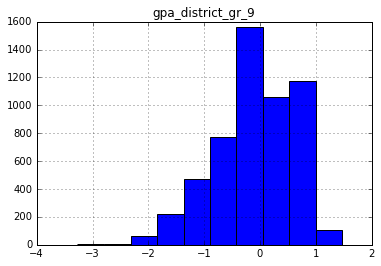

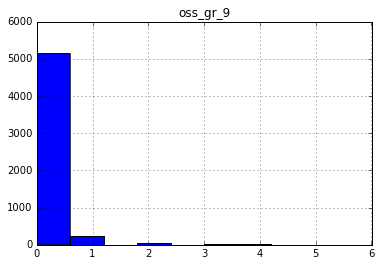

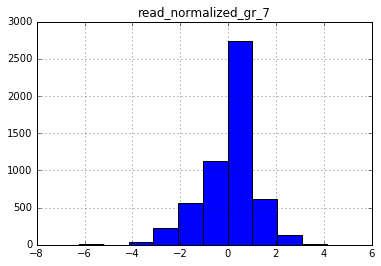

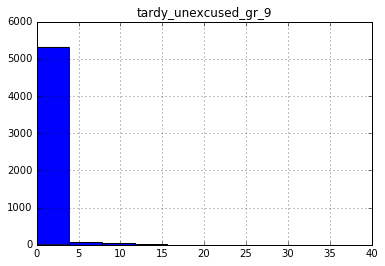

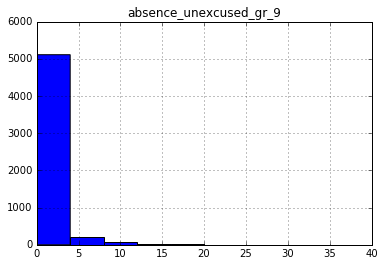

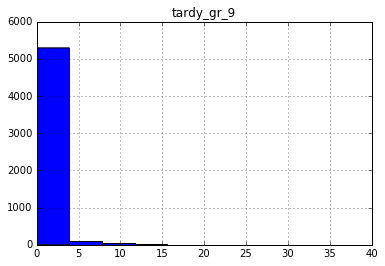

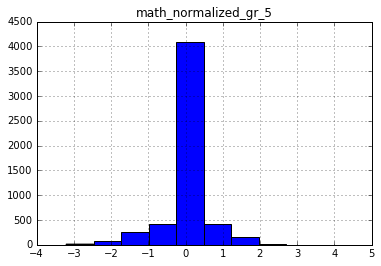

In [19]:
for c in train_X.columns[train_X.columns.isin(scores[~scores['binary']].index)]:
    plt.figure()
    train_X[c].hist()
    plt.title(c)

In [20]:
scores_weighted = scores
scores_weighted[~scores_weighted['binary']] = scores[~scores['binary']][['importance']]*5

In [21]:
scores.sort_values('importance',ascending=False)

importance  binary
gpa_gr_9                                4.927894e-01     NaN
gpa_district_gr_9                       4.535534e-01     NaN
math_normalized_gr_8                    3.065383e-01     NaN
absence_gr_9                            2.914977e-01     NaN
read_normalized_gr_8                    2.881030e-01     NaN
math_normalized_gr_7                    2.229650e-01     NaN
read_normalized_gr_7                    2.043348e-01     NaN
math_normalized_gr_6                    2.022955e-01     NaN
math_normalized_gr_4                    1.897594e-01     NaN
science_normalized_gr_8                 1.872084e-01     NaN
read_normalized_gr_6                    1.779580e-01     NaN
discipline_incidents_gr_9               1.776112e-01     NaN
read_normalized_gr_4                    1.755337e-01     NaN
oss_gr_9                                1.375567e-01     NaN
read_normalized_gr_5                    1.012060e-01     NaN
iss_gr_9                                9.163365e-02     NaN
math_normalized_gr_5                    7.590861e-02     NaN
absence_unexcused_gr_9                  7.412297e-02     NaN
read_normalized_gr_3                    6.269002e-02     NaN
tardy_gr_9                              5.287705e-02     NaN
tardy_unexcused_gr_9                    5.162719e-02     NaN
science_normalized_gr_5                 5.044765e-02     NaN
socstudies_normalized_gr_5              4.310548e-02     NaN
math_normalized_gr_3                    3.576428e-02     NaN
disadvantagement_gr_9_economic          1.314124e-02     1.0
status_gr_9_inactive                    8.657718e-03     1.0
math_normalized_gr_7_isnull             5.876465e-03     1.0
gpa_district_gr_9_isnull                5.728690e-03     1.0
gender_F                                5.651598e-03     1.0
math_normalized_gr_4_isnull             5.273094e-03     1.0
...                                              ...     ...
disability_gr_9_emotional disturbance   2.566121e-03     1.0
ethnicity_M                             2.473037e-03     1.0
socstudies_normalized_gr_5_isnull       2.276134e-03     1.0
science_normalized_gr_5_isnull          2.081139e-03     1.0
disadvantagement_gr_9_both              1.632633e-03     1.0
district_gr_9_East Muskingum            1.539065e-03     1.0
section_504_plan_gr_9_Y                 1.243439e-03     1.0
status_gr_9_excel                       1.243139e-03     1.0
disability_gr_9_other minor             1.219326e-03     1.0
district_gr_9_Crooksville               1.186885e-03     1.0
district_gr_9_Zanesville                1.017383e-03     1.0
status_gr_9_esc                         9.892983e-04     1.0
ethnicity_B                             9.454850e-04     1.0
ethnicity_nan                           7.568654e-04     1.0
disability_gr_9_multiple                5.837890e-04     1.0
disability_gr_9_autism                  5.218101e-04     1.0
disability_gr_9_other major             4.613313e-04     1.0
ethnicity_H                             3.821010e-04     1.0
disadvantagement_gr_9_academic          2.434704e-04     1.0
ethnicity_A                             1.621201e-04     1.0
limited_english_gr_9_L                  9.235545e-05     1.0
status_gr_9_deleted                     4.585265e-05     1.0
disability_gr_9_visual impairment       2.734659e-05     1.0
district_gr_9_New Lexington City SD     2.201713e-05     1.0
status_gr_9_6                           1.757271e-05     1.0
ethnicity_I                             1.212209e-06     1.0
special_ed_gr_9_89                      3.099821e-09     1.0
disability_gr_9_deafness                0.000000e+00     1.0
status_gr_9_three_way                   0.000000e+00     1.0
disability_gr_9_traumatic brain injury  0.000000e+00     1.0

[84 rows x 2 columns]

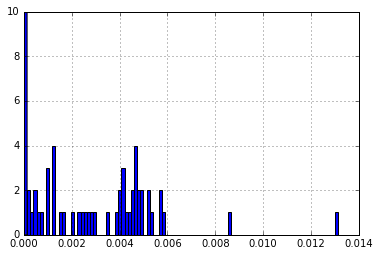

In [22]:
scores[scores['binary']==1]['importance'].hist(bins=100)

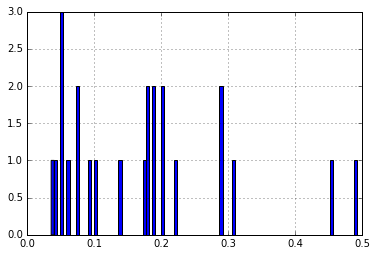

In [23]:
(scores[~(scores['binary']==1)]['importance']).hist(bins=100)

In [24]:
scores[~(scores['binary']==1)].sort_values('importance')

importance  binary
math_normalized_gr_3          0.035764     NaN
socstudies_normalized_gr_5    0.043105     NaN
science_normalized_gr_5       0.050448     NaN
tardy_unexcused_gr_9          0.051627     NaN
tardy_gr_9                    0.052877     NaN
read_normalized_gr_3          0.062690     NaN
absence_unexcused_gr_9        0.074123     NaN
math_normalized_gr_5          0.075909     NaN
iss_gr_9                      0.091634     NaN
read_normalized_gr_5          0.101206     NaN
oss_gr_9                      0.137557     NaN
read_normalized_gr_4          0.175534     NaN
discipline_incidents_gr_9     0.177611     NaN
read_normalized_gr_6          0.177958     NaN
science_normalized_gr_8       0.187208     NaN
math_normalized_gr_4          0.189759     NaN
math_normalized_gr_6          0.202296     NaN
read_normalized_gr_7          0.204335     NaN
math_normalized_gr_7          0.222965     NaN
read_normalized_gr_8          0.288103     NaN
absence_gr_9                  0.291498     NaN
math_normalized_gr_8          0.306538     NaN
gpa_district_gr_9             0.453553     NaN
gpa_gr_9                      0.492789     NaN

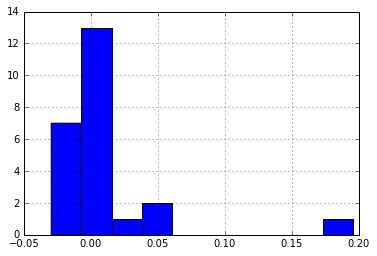

In [25]:
(train_X[train_X.columns[~(scores['binary']==1)]]*scores['importance'][~(scores['binary']==1)]).mean(axis=0).hist()


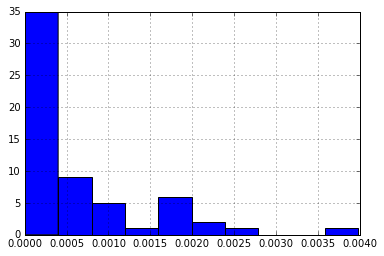

In [26]:
(train_X[train_X.columns[(scores['binary']==1)]]*scores['importance'][(scores['binary']==1)]).mean(axis=0).hist()


In [27]:
pd.DataFrame((train_X*scores['importance']).mean(axis=0), columns=['importance']).sort_values('importance', ascending=False)

importance
discipline_incidents_gr_9               1.960410e-01
absence_gr_9                            5.289430e-02
absence_unexcused_gr_9                  5.251364e-02
tardy_gr_9                              1.655746e-02
tardy_unexcused_gr_9                    1.541704e-02
oss_gr_9                                1.058517e-02
iss_gr_9                                1.051810e-02
math_normalized_gr_4                    6.605690e-03
math_normalized_gr_7                    5.452693e-03
disadvantagement_gr_9_economic          3.987020e-03
gender_F                                2.728751e-03
math_normalized_gr_3_isnull             2.246685e-03
read_normalized_gr_3_isnull             2.056390e-03
socstudies_normalized_gr_5_isnull       1.841390e-03
math_normalized_gr_5_isnull             1.832145e-03
special_ed_gr_9_100                     1.764104e-03
read_normalized_gr_5_isnull             1.723739e-03
science_normalized_gr_5_isnull          1.684022e-03
science_normalized_gr_8                 1.600860e-03
section_504_plan_gr_9_nan               1.597449e-03
math_normalized_gr_4_isnull             1.321905e-03
read_normalized_gr_4_isnull             1.174322e-03
read_normalized_gr_7_isnull             1.111305e-03
science_normalized_gr_8_isnull          1.013414e-03
math_normalized_gr_7_isnull             8.234605e-04
read_normalized_gr_6_isnull             8.135970e-04
math_normalized_gr_6_isnull             7.464627e-04
district_gr_9_Riverview                 7.372297e-04
read_normalized_gr_3                    7.008867e-04
district_gr_9_Maysville                 6.048450e-04
...                                              ...
disability_gr_9_multiple                1.608234e-06
district_gr_9_Zanesville                1.121084e-06
status_gr_9_excel                       9.132333e-07
ethnicity_H                             8.420958e-07
disadvantagement_gr_9_academic          4.918594e-07
ethnicity_A                             4.466118e-07
ethnicity_nan                           4.170057e-07
disability_gr_9_other major             2.541770e-07
limited_english_gr_9_L                  1.696152e-08
status_gr_9_deleted                     1.684211e-08
disability_gr_9_visual impairment       1.506699e-08
district_gr_9_New Lexington City SD     4.043550e-09
status_gr_9_6                           3.227312e-09
ethnicity_I                             4.452559e-10
special_ed_gr_9_89                      5.692968e-13
status_gr_9_three_way                   0.000000e+00
disability_gr_9_deafness                0.000000e+00
disability_gr_9_traumatic brain injury  0.000000e+00
math_normalized_gr_3                   -2.384045e-04
science_normalized_gr_5                -7.134238e-04
math_normalized_gr_5                   -1.024421e-03
read_normalized_gr_5                   -1.531634e-03
math_normalized_gr_8                   -4.646120e-03
read_normalized_gr_6                   -7.164558e-03
read_normalized_gr_4                   -8.811950e-03
math_normalized_gr_6                   -1.076905e-02
read_normalized_gr_7                   -1.098298e-02
read_normalized_gr_8                   -1.133752e-02
gpa_gr_9                               -1.981117e-02
gpa_district_gr_9                      -2.966512e-02

[84 rows x 1 columns]

In [28]:
student = 42545

In [29]:
X = train_X.loc[student]

In [37]:
(scores['importance'].multiply(X,axis='index')).sort_values()

gpa_district_gr_9                        -0.575723
gpa_gr_9                                 -0.472642
absence_gr_9                             -0.226720
science_normalized_gr_5                   0.000000
math_normalized_gr_6                      0.000000
read_normalized_gr_5                      0.000000
gpa_district_gr_9_isnull                  0.000000
gpa_gr_9_isnull                           0.000000
gender_F                                  0.000000
status_gr_9_6                             0.000000
ethnicity_M                               0.000000
ethnicity_I                               0.000000
ethnicity_H                               0.000000
ethnicity_B                               0.000000
ethnicity_A                               0.000000
tardy_gr_9                                0.000000
discipline_incidents_gr_9                 0.000000
math_normalized_gr_7                      0.000000
district_gr_9_Zanesville                  0.000000
read_normalized_gr_8           